# Part1:TwitterNetwork Analysis

Exercise 1: Build the network of retweets. We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets. You can build the network following the steps below (and you should be able to reuse many of the functions you have written as part of the exercises during the previous weeks):

- Consider the 200 most recent tweets written by each member of the house (use the files here. For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "RT @originalAuthor:", where "originalAuthor" is the handle of the user whose content was retweeted (and the part of the text you want to extract).

In [1]:
import os
import nltk, re, pprint
from nltk import word_tokenize
import networkx as nx

# get the filename from tweets_2019_full
os.chdir(r"	weets_2019_full")
names=os.listdir()

# Store tweets in dictionary
twe_dir={}
for name in names:
    f=open(r"tweets_2019_full/"+name,encoding='utf8')
    twe_dir[name]=f.read()
    f.close()  

In [2]:
# read a table containing WikiPageName and handle names
import pandas as pd
df=pd.read_csv("H115_tw_2019.csv",encoding='utf8')

In [3]:
# retweet dictionary (mapping name of retweeting user to retweet)
ret_ls=[(name,tw)   for name in names for tw in twe_dir[name].split("\n") if tw.startswith('RT ')]
ret_dict=dict()
for name in set(name for (name,tw) in ret_ls):
    ls=[pair[1] for pair in ret_ls if pair[0]==name]
    ret_dict[name]=ls

# retweet dictionary (mapping name of retweeting user to retweeted user's name  )
ret_dict_to_whom={}
for name in set(name for (name,tw) in ret_ls):
    ls=[]
    for pair in ret_ls:
        if pair[0]==name:
            ls.extend(re.findall(r'RT @\w+',pair[1]))
                
    ret_dict_to_whom[name]=ls

- For each retweet, check if the handle retweeted is, in fact, the handle of a member of the house. If yes, keep it. If no, discard it.

- Use a NetworkX DiGraph to store the network. Use weighted edges to account for multiple retweets. Also store the party of each member as a node attribute (use the data in this file. Remove self-loops (edges that connect a node with itself).

In [4]:
# make dictionaries to convert WikiPageName into handle name and vice varsa
wiki_to_tw={ filename: list(df.query('WikiPageName ==  "{}" '.format(filename))['tw_name'])[0] for filename in names}
tw_to_wiki={  list(df.query('WikiPageName ==  "{}" '.format(filename))['tw_name'])[0]:filename for filename in names}

# dictionary of retweet within house 
house_ret_dict={}
for name in ret_dict_to_whom.keys():
    house_ret_dict[name]=[tw_to_wiki[user[4:]] for user in ret_dict_to_whom[name] if user[4:] in wiki_to_tw.values()]
  

In [5]:
# make a weighted directed graph
G=nx.DiGraph()
links=[]
for ini_node in house_ret_dict.keys():
    pair=[(ini_node,end_node) for end_node in house_ret_dict[ini_node]]
    links.extend(pair)
    
edges=[(n1,n2,float(dict(nltk.FreqDist(links))[(n1,n2)])) for n1,n2 in set(dict(nltk.FreqDist(links)).keys()) if not n1==n2]
nodes=house_ret_dict.keys()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)


Exercise 2: Visualize the network of retweets and investigate differences between the parties.

- Visualize the network using the Networkx draw function, and nodes coordinates from the force atlas algorithm. Hint: use an undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements. Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the node-size to be proportional to total degree.

In [6]:

import numpy as np
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

# dectionary mapping WikiPageName to party
party_dict={ node : list(df.query('WikiPageName=="{}"'.format(node))['Party'])[0] for node in nodes}

# name list of Rep and Dem
rep=[name for name in nodes if party_dict[name]=='Republican']
dem=[name for name in nodes if party_dict[name]=='Democratic']

# force atlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=30.0,

                        # Log
                        verbose=True)




In [7]:
# network extracted from wikipedia

import re
import networkx as nx
from urllib.parse import quote

os.chdir(r"C:/Users/Takuya/Desktop/DTU/social")
df115=pd.read_csv('H115.csv')
df115['congress_number']=115
wiki_nodes=list(df115.WikiPageName.groupby(df115.WikiPageName).size().index)


g_wiki=nx.DiGraph()
g_wiki.add_nodes_from(wiki_nodes)
wikilink=[]
for mem in wiki_nodes:
    try:
        f=open("./data_of_USrep115/"+quote(mem)+'.txt','r')
        text=f.read()
        link=re.findall(r'\[\[.*?\]?\]',text)
    
    except:
        pass

    wikilink.extend([(mem,re.findall(r'[^\|]*',link[x])[0][2:][:-2].replace(r' ',r'_') ) for x in range(len(link)) if re.findall(r'[^\|]*',link[x])[0][2:][:-2].replace(r' ',r'_') in wiki_nodes])
    
g_wiki.add_edges_from(wikilink)  


# name list of Rep and Dem
rep_wiki=[x for x in wiki_nodes if (df115.loc[df115['WikiPageName']==x].Party=="Republican").bool()]
dem_wiki=[x for x in wiki_nodes if (df115.loc[df115['WikiPageName']==x].Party=="Democratic").bool()]

# force atlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=30.0,

                        # Log
                        verbose=True)

100%|██████████| 2000/2000 [00:14<00:00, 138.59it/s]


BarnesHut Approximation  took  1.64  seconds
Repulsion forces  took  12.01  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


C:\Users\Takuya\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Takuya\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


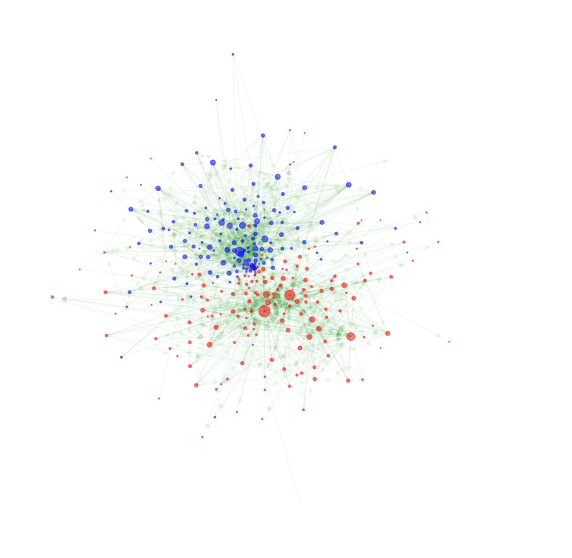

In [8]:
# draw wikipedia network using node degree

plt.figure(figsize=(10, 10))
positions1 = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

#draw nodes in Rep
nx.draw_networkx_nodes(G.subgraph(rep) ,positions1,node_size=list(dict(G.subgraph(rep).degree).values()), with_labels=False, node_color="red", alpha=0.5)

#draw nodes in Dem
nx.draw_networkx_nodes(G.subgraph(dem) ,positions1,node_size=list(dict(G.subgraph(dem).degree).values()), with_labels=False, node_color="blue", alpha=0.5)

#draw edges
nx.draw_networkx_edges(G, positions1, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()


100%|██████████| 2000/2000 [00:20<00:00, 95.49it/s] 


BarnesHut Approximation  took  2.23  seconds
Repulsion forces  took  17.68  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.38  seconds


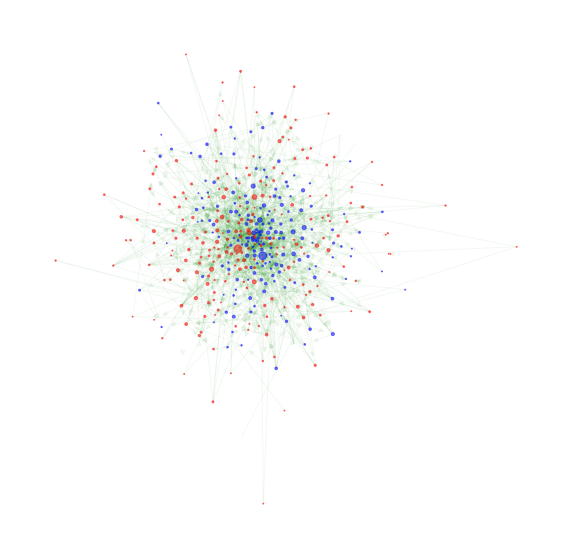

In [9]:
# draw wikipedia network using node degree

plt.figure(figsize=(10, 10))
positions2 = forceatlas2.forceatlas2_networkx_layout(g_wiki, pos=None, iterations=2000)

#draw nodes in Rep
nx.draw_networkx_nodes(g_wiki.subgraph(rep_wiki) ,positions2,node_size=[1*d for d in list(dict(g_wiki.subgraph(rep_wiki).degree).values())], with_labels=False, node_color="red", alpha=0.5)

#draw nodes in Dem
nx.draw_networkx_nodes(g_wiki.subgraph(dem_wiki) ,positions2,node_size=[1*d for d in list(dict(g_wiki.subgraph(dem_wiki).degree).values())], with_labels=False, node_color="blue", alpha=0.5)

#draw edges
nx.draw_networkx_edges(g_wiki, positions2, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

    - Compare the network of Retweets with the network of Wikipedia pages (generated during Week 5). Do you observe any differences? How do you explain them?

Differences between the are distribution of node size and that while member in each party is connected to same party member mainly in twitter network, in wikipedia network, there seem not to be any feature seen in twitter.

That is, links to another politician tend not to appear in wikipedia page, campared to the frequency of retweet, and not to connect to members of certain party.

This reason ia that wikipedia often contains information about elctions, e.g. who was a political enemy, therefore difference between link numbers to each party member tend not to be large, however, member of certain party tend to send personal messages (e.g. https://pbs.twimg.com/media/B1nJC2GCEAA_ogG.jpg)

    - Now set the node-size tob proportional to betweenness centrality. Do you observe any changes? Repeat the point above using eigenvector centrality. Again, do you see a difference? Can you explain why based on what eigenvector centrality measures?
    
Both node sizes of Rep and Dem increased at same extent from privious twitter network. While relatively larger nodes in previous one stay lager, node sizes around the border of Rep and Dem increased.
That is because these nodes become a "bridge" between Rep and Dem.

In the network using eigenvector centrality, node sixes in Rep became much larger compared to these in Dem. By the feature of eigenvector centrality, centrality of node tend to be high when centralities of its neighbor are high, it is because node in Rep tend to connect to nodes in Rep and not to these in Dem.

In [10]:
# caluculation of between centrality
bet_cent=nx.betweenness_centrality(G)
rep_bet_cent={name:bet_cent[name]*5000 for name in list(G.subgraph(rep).node)}
dem_bet_cent={name:bet_cent[name]*5000 for name in list(G.subgraph(dem).node)}

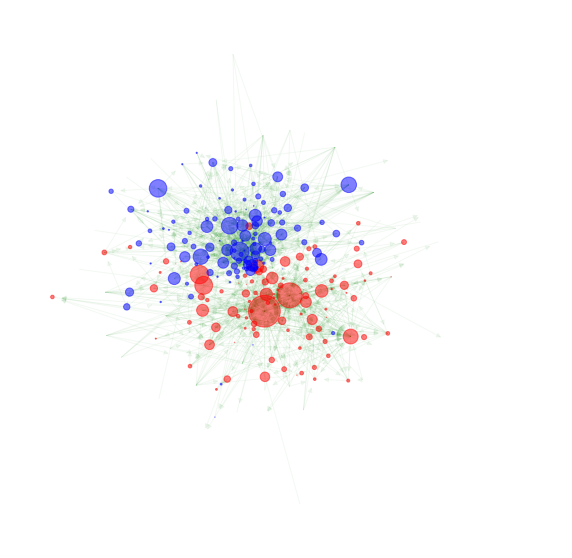

In [11]:
# draw twitter network using between centrality
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G.subgraph(rep) ,positions1, node_size=list(rep_bet_cent.values()), with_labels=False, node_color="red", alpha=0.5)
nx.draw_networkx_nodes(G.subgraph(dem) ,positions1, node_size=list(dem_bet_cent.values()), with_labels=False, node_color="blue", alpha=0.5)
nx.draw_networkx_edges(G, positions1, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()


In [12]:
# caluculation of eigenvector centrality
eig_cent=nx.eigenvector_centrality(G)
rep_eig_cent={name:eig_cent[name]*2000 for name in list(G.subgraph(rep).node)}
dem_eig_cent={name:eig_cent[name]*2000 for name in list(G.subgraph(dem).node)}

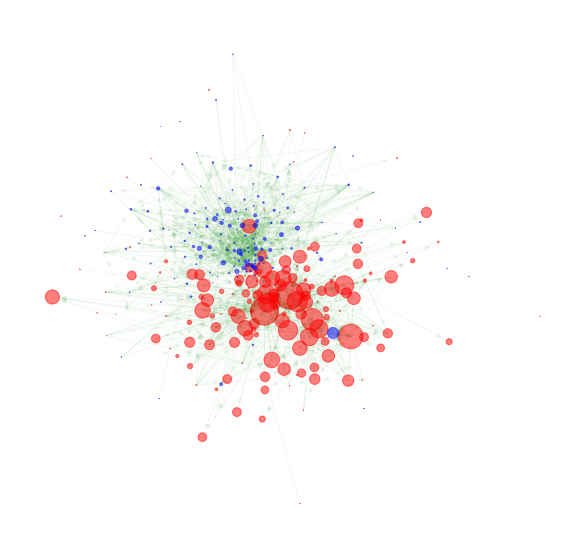

In [13]:
# draw twitter network using eigenvector centrality
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G.subgraph(rep) ,positions1, node_size=list(rep_eig_cent.values()), with_labels=False, node_color="red", alpha=0.5)
nx.draw_networkx_nodes(G.subgraph(dem) ,positions1, node_size=list(dem_eig_cent.values()), with_labels=False, node_color="blue", alpha=0.5)
nx.draw_networkx_edges(G, positions1, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()


    - Who are the three nodes with highest degree within each party? And wbat is their eigenvector centrality? And their betweenness centrality?


In [14]:
# degree
print("Rep:{}".format(sorted(G.subgraph(rep).degree,key=lambda x:x[1],reverse=True)[:3]))
print()
print("Dem:{}".format(sorted(G.subgraph(dem).degree,key=lambda x:x[1],reverse=True)[:3]))

Rep:[('Kevin_McCarthy_(California_politician)', 126), ('Steve_Scalise', 97), ('Andy_Biggs', 59)]

Dem:[('Nancy_Pelosi', 76), ('Linda_Sánchez', 35), ('Raúl_Grijalva', 35)]


In [15]:
# betweenness centrality?
print("Rep:{}".format(sorted(rep_bet_cent.items(),key=lambda x:x[1],reverse=True)[:3]))
print()
print("Dem:{}".format(sorted(dem_bet_cent.items(),key=lambda x:x[1],reverse=True)[:3]))

Rep:[('Kevin_McCarthy_(California_politician)', 1012.7124476434009), ('Steve_Scalise', 621.3774929360188), ('Fred_Upton', 343.66436221349)]

Dem:[('Nancy_Pelosi', 353.48190600760137), ('Ted_Deutch', 309.1249637570316), ('Bobby_Scott_(politician)', 279.841497914349)]


In [16]:
#eigenvector centrality
print("Rep:{}".format(sorted(rep_eig_cent.items(),key=lambda x:x[1],reverse=True)[:3]))
print()
print("Dem:{}".format(sorted(dem_eig_cent.items(),key=lambda x:x[1],reverse=True)[:3]))

Rep:[('Kevin_McCarthy_(California_politician)', 779.2478868502617), ('Steve_Scalise', 758.9047811908821), ('Andy_Biggs', 600.2000244497447)]

Dem:[('Gene_Green', 125.06078437505519), ('Zoe_Lofgren', 32.177496690826004), ('Nancy_Pelosi', 27.28887455243765)]


    - Plot (on the same figure) the distribution of outgoing strength for the republican and democratic nodes repectively (i.e. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?



In [17]:
def draw_distribution(ls):
    import numpy as np
    histo_data=np.histogram(ls,bins=int(max(ls)))
    X = []
    for i in range(1, len(histo_data[1])):
        X.append((histo_data[1][i-1]+histo_data[1][i])/2)
    plt.plot(X,histo_data[0])
    plt.xlabel("out degree")
    plt.ylabel("count")

    
def draw_distribution_log(ls):
    import numpy as np
    histo_data=np.histogram(ls,bins=int(max(ls)))
    X = []
    for i in range(1, len(histo_data[1])):
        X.append((histo_data[1][i-1]+histo_data[1][i])/2)
    plt.plot(X,histo_data[0])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("k")
    plt.ylabel("count")

out_deg=G.out_degree(weight='weight')
rep_out_deg=[(name,out_deg[name]) for name in rep]
dem_out_deg=[(name,out_deg[name]) for name in dem]

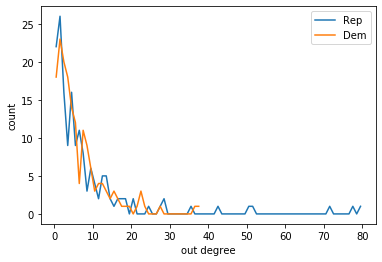

In [18]:
fig, ax = plt.subplots(facecolor="w")
draw_distribution(list(dict(rep_out_deg).values()))
draw_distribution(list(dict(dem_out_deg).values()))
ax.legend(["Rep", "Dem"])

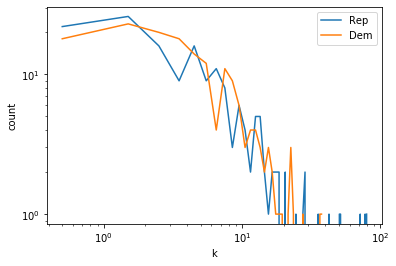

In [19]:
fig, ax = plt.subplots(facecolor="w")
draw_distribution_log(list(dict(rep_out_deg).values()))
draw_distribution_log(list(dict(dem_out_deg).values()))
ax.legend(["Rep", "Dem"])

From these figures, it can be understood that members of Rep have high out degree. Especialy, there are nodes whose out degree are more than 40 in Rep, but there isn't in Dem.

    - Find the 3 members of the republican party that have retweeted tweets from democratic members most often. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [20]:
# list of link from Rep [resp. Dem] to Dem [resp. Rep]
rep_to_dem=[edge[0] for edge in G.edges if edge[0] in rep and edge[1] in dem]
dem_to_rep=[edge[0] for edge in G.edges if edge[1] in rep and edge[0] in dem]

# culculate frequency of 
fd_rtod=dict(nltk.FreqDist(rep_to_dem))
fd_dtor=dict(nltk.FreqDist(dem_to_rep))

In [21]:
print("From Rep to Dem:{}".format(sorted(set((e,fd_rtod[e]) for e in rep_to_dem),key=lambda x:x[1],reverse=True)[:3]))

From Rep to Dem:[('Brian_Fitzpatrick_(American_politician)', 8), ('Tom_Reed_(politician)', 3), ('Jim_Sensenbrenner', 3)]


In [22]:
print("From Dem to Rep:{}".format(sorted(set((e,fd_dtor[e]) for e in dem_to_rep),key=lambda x:x[1],reverse=True)[:3]))

From Dem to Rep:[('Gene_Green', 6), ('Ted_Deutch', 4), ('Cedric_Richmond', 4)]


Exercise 3: Community detection.

- Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network (Week 7)? Comment on your result.



In [23]:
import community
import matplotlib.colors as clr
import matplotlib.cm as cm
uG=G.to_undirected()
uG_wiki=g_wiki.to_undirected()

partition=community.best_partition(uG,weight='weight')
partition_wiki=community.best_partition(uG_wiki)

# modularity
print("modularity of twitter is little but larger than wikipedia:")
print("     modularity of twitter:{}".format(community.modularity(partition, uG, weight='weight')))
print("     modularity of wikipedia:{}".format(community.modularity(partition_wiki, uG_wiki)))


modularity of twitter is little but larger than wikipedia:
     modularity of twitter:0.48548789234521805
     modularity of wikipedia:0.4671508014355247


We got a relatively smaller value than expected. But as you can see from the below confusing matrix, partition of wikipedia network is not suitale for telling party apart.

- Visualize the network, using the Force Atlas algorithm. This time assign each node a different color based on their community. Describe the structure you observe.



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

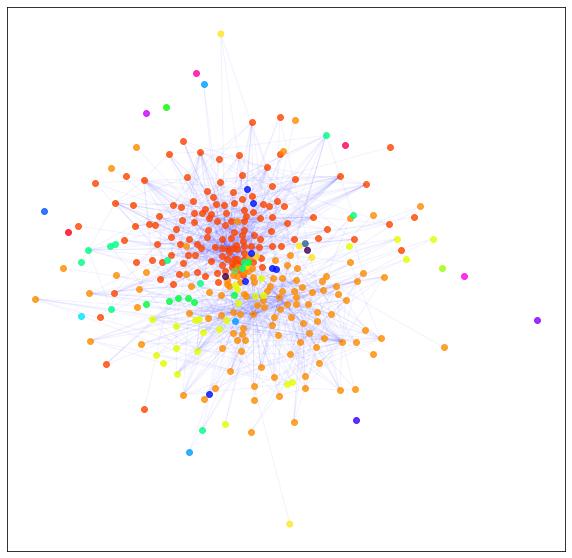

In [24]:
# clustering twitter network by louvain method
size = float(len(set(partition.values())))
count=.0

plt.figure(figsize=(10, 10))
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(uG.subgraph(list_nodes), positions1, list_nodes,node_size=35,
                                node_color =cm.hsv(count/int(size)),alpha=0.8)
nx.draw_networkx_edges(uG,positions1, alpha=0.05,edge_color='b')
plt.show()


Briefly, there are two clusters separated by a border line in the center.(Orange part is Dem, the other is Rep) Furthermore, the part, that is not orange, is separated in two, yellow cluster and red cluster.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

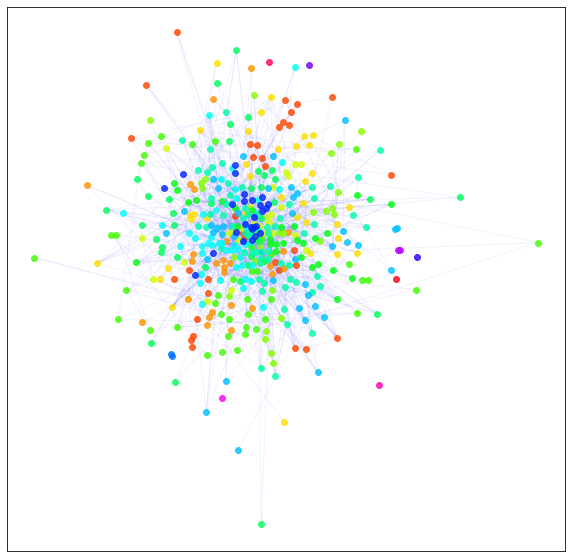

In [25]:
# clustering wikipedia network by louvain method

size_wiki = float(len(set(partition_wiki.values())))
count=.0

plt.figure(figsize=(10, 10))
for com in set(partition_wiki.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition_wiki.keys()
                                if partition_wiki[nodes] == com]
    nx.draw_networkx_nodes(uG_wiki.subgraph(list_nodes), positions2, list_nodes,node_size=35,
                                node_color =cm.hsv(count/int(size_wiki)),alpha=0.8)
nx.draw_networkx_edges(uG_wiki,positions2, alpha=0.05,edge_color='b')
plt.show()


- Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.



In [26]:
cluster_nodes={i:set(name for name in partition.keys() if partition[name]==i) for i in range(int(size))}
D=[ [len(set(rep).intersection(cluster_nodes[i])) for i in range(int(size))],[len(set(dem).intersection(cluster_nodes[i])) for i in range(int(size))]]

cluster_nodes_wiki={i:set(name for name in partition_wiki.keys() if partition_wiki[name]==i) for i in range(int(size_wiki))}
D_wiki=[ [len(set(rep_wiki).intersection(cluster_nodes_wiki[i])) for i in range(int(size_wiki))],[len(set(dem_wiki).intersection(cluster_nodes_wiki[i])) for i in range(int(size_wiki))]]

In [27]:
print("confusion matrix using twitter network")
print(D[0])
print(D[1])
print()
print("confusion matrix using wikipedia network")
print(D_wiki[0])
print(D_wiki[1])



confusion matrix using twitter network
[5, 113, 1, 24, 0, 2, 0, 4, 4, 1, 1, 2, 1, 4, 0, 1, 0, 0, 1, 0, 0]
[135, 4, 2, 0, 1, 2, 1, 3, 7, 3, 0, 1, 0, 3, 1, 0, 1, 1, 0, 1, 1]

confusion matrix using wikipedia network
[21, 15, 14, 17, 15, 19, 14, 29, 23, 35, 29, 1, 13, 0, 0, 2, 1, 0, 1, 0]
[13, 12, 20, 18, 11, 23, 15, 7, 43, 6, 10, 1, 13, 1, 1, 0, 0, 1, 0, 1]


- Use the confusion matrix to explain how well the communities you've -detected correspond to the parties. Consider the following questions

    -Are there any republicans grouped with democrats (and vice versa)?
    
    -Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

Yes, although the largest cluster seems completely divide the house into party, some members (about 5, but it depends on result of partition) are clusterd in the other cluster.

Members in Rep are sub-divided by the algorithm, but the results (which group they are divided in) depends on trial.
In some trials, we got an interesting result that 17 of 22 members of a subgroup are in congress sponsored by the NRA in the 2016 cycle. (cf. https://gist.github.com/johan/69d217d41957a691e8ebb0f9d0b52e09#file-index-html)